In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Compare

In [2]:
import Data_prep
def print_stats(df):
    user_ratings = df.groupby('user')['rating'].count()
    item_ratings = df.groupby('item')['rating'].count()
    norpu = user_ratings.mean()
    norpi = item_ratings.mean()
    total_users = df.user.unique().size
    total_items = df.item.unique().size
    sparseness = 1 - len(df) / (len(df['user'].unique()) * len(df['item'].unique()))
    
    BATCH_SIZE = 64
    val_perc = test_perc = 0.1
    n_last_items_val = n_last_items_test = 1
    total_users, total_items, train_set, val_set, test_set = \
    Data_prep.train_val_test_split(df, BATCH_SIZE, val_perc, test_perc, n_last_items_val, n_last_items_test)
    
    print('rows ', len(df), 
          '\n#ratings/user', round(norpu,2), 
          '\n#ratings/item', round(norpi,2), 
          '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), 
          '\n#users ', df['user'].unique().size, 
          '\n#items ', df['item'].unique().size, 
          '\nsparse ', round(sparseness,5))

In [3]:
def show_results(metrics, file_name, plot_title, legend_names, size=(10,8), path=''):
    ranks_at = metrics[0]['rank_at']
    
    figure, axes = plt.subplots(nrows=2, ncols=2, figsize=size)
    figure.suptitle(plot_title)
    figure.subplots_adjust(wspace=0.4, hspace=0.4)
        
    bar_width = 1.0
    bar_dist = 1.0
    line_width = 2
    title_size = 'large'
    
    #Plots
    for i, m in enumerate(metrics):
        axes[0,0].plot(ranks_at, m['recall'], linewidth=line_width)
        axes[0,1].plot(ranks_at, m['precision'], linewidth=line_width)
        axes[1,0].bar(ranks_at[1:] + i*bar_dist, m['hitcounts'][1:], width=bar_width, align='center')
        axes[1,1].bar(ranks_at[0] + i*bar_dist, m['hitcounts'][0], width=bar_width, align='center')

    # Decoration
    ## Recall@1-20    
    for i, rank in enumerate(ranks_at):
        top = max([m['recall'][i] for m in metrics])
        axes[0,0].vlines(rank, 0, top, linestyle = '--', color='gainsboro', linewidth=line_width/2) 
    axes[0,0].set_title('Recall@1-20', fontsize=title_size)
    axes[0,0].set_xlabel('Rank@')
    axes[0,0].set_ylabel('Recall')
    
    ## Precision@1-20    
    for i, rank in enumerate(ranks_at):
        top = max([m['precision'][i] for m in metrics])
        axes[0,1].vlines(rank, 0, top, linestyle = '--', color='gainsboro', linewidth=line_width/2) 
    axes[0,1].set_title('Precision@1-20', fontsize=title_size)
    axes[0,1].set_xlabel('Rank@')
    axes[0,1].set_ylabel('Precision')
     
    ## Hitcounts@5-20
    axes[1,0].set_title('Hitcounts@5-20', fontsize=title_size)
    axes[1,0].set_xlabel('Rank@')
    axes[1,0].set_ylabel('Hitcounts')
    axes[1,0].set_xlim([1,24])
    axes[1,0].set_xticks(ranks_at[1:])
    
    ## Hitcounts@1
    axes[1,1].set_title('Hitcounts@1', fontsize=title_size)
    axes[1,1].set_xlabel('Rank@1')
    axes[1,1].set_ylabel('Hitcounts')
    axes[1,1].set_xticks([])
    
    figure.legend(legend_names, loc='lower center', ncol=len(legend_names), fontsize='large')
    
    if len(store_path) > 0:
        figure.savefig(path + file_name + '_results')
    plt.show()

## Init

In [6]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'

In [5]:
names_am = ['Amazon_01_users']
names_ml = ['ML_01_users', 'ML_01_users']
extensions = ['', '', '_rate_above_3']

res_path = path + 'Results/Results_17_04/'
store_path = '' #path + 'Plots/CFRNN_plots/'
file_names = names_am + names_ml
data_paths = ['Data/Amazon/']*len(names_am) + ['Data/ML/']*len(names_ml)
plot_titles = ['Amazon 10%', 'MovieLens 10%', 'MovieLens 10% rate above 3']

In [6]:
legend_names = ['BPR', 'Random', 'Popularity']

## Plot All

Total number of items: 247465
Total users: 121372
Number of train users: 121344
Number of test users: 12160
Number of validation users: 12160 

Users deleted: 28
rows  1058788 
#ratings/user 8.72 
#ratings/item 4.28 
average rating 4.28 
#users  121372 
#items  247465 
sparse  0.99996


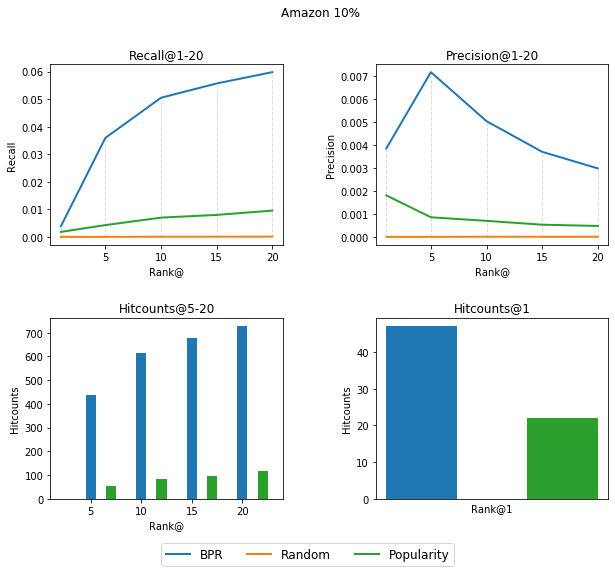

Total number of items: 27387
Total users: 16254
Number of train users: 16192
Number of test users: 1664
Number of validation users: 1664 

Users deleted: 62
rows  2446037 
#ratings/user 150.49 
#ratings/item 89.31 
average rating 3.55 
#users  16254 
#items  27387 
sparse  0.99451


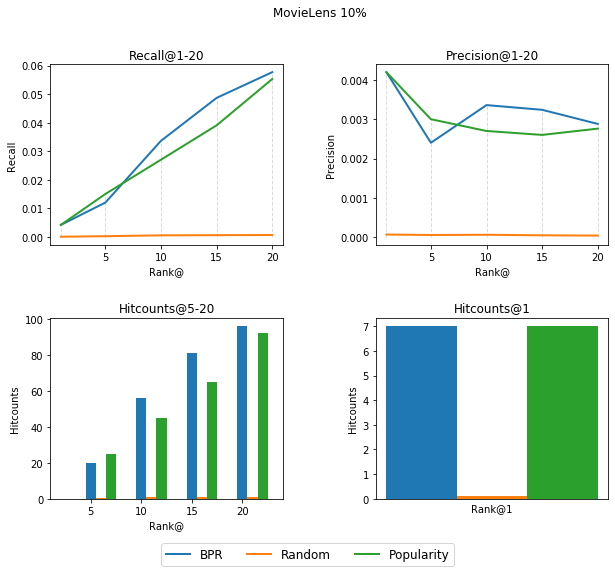

Total number of items: 27387
Total users: 16254
Number of train users: 16192
Number of test users: 1664
Number of validation users: 1664 

Users deleted: 62
rows  2446037 
#ratings/user 150.49 
#ratings/item 89.31 
average rating 3.55 
#users  16254 
#items  27387 
sparse  0.99451


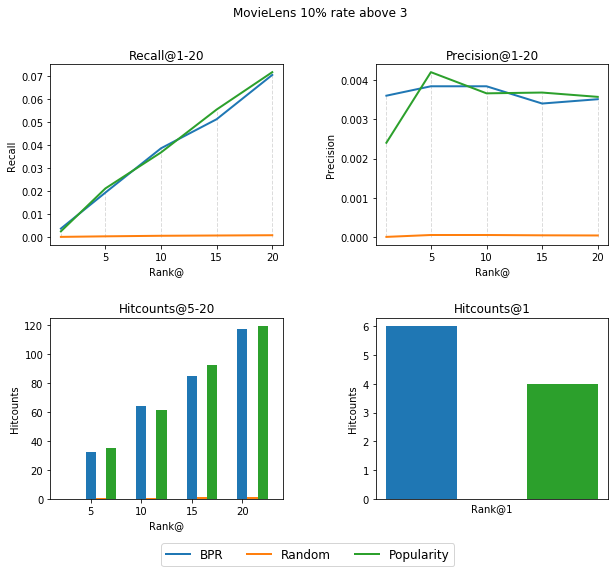

In [17]:
for file_name, data_path, ext, title in zip(file_names, data_paths, extensions, plot_titles):
    df = pd.read_pickle(path + data_path + file_name)
    print_stats(df)
    
    bpr = pd.read_pickle(res_path + 'metrics_bpr_' + file_name + ext)
    rand = pd.read_pickle(res_path + 'rand_bench_' + file_name + ext)
    pop = pd.read_pickle(res_path + 'pop_bench_' + file_name + ext)
    
    all_metrics = [bpr, rand, pop]
    show_results(all_metrics, file_name, title, legend_names, path=store_path)

## Plot CFRNN

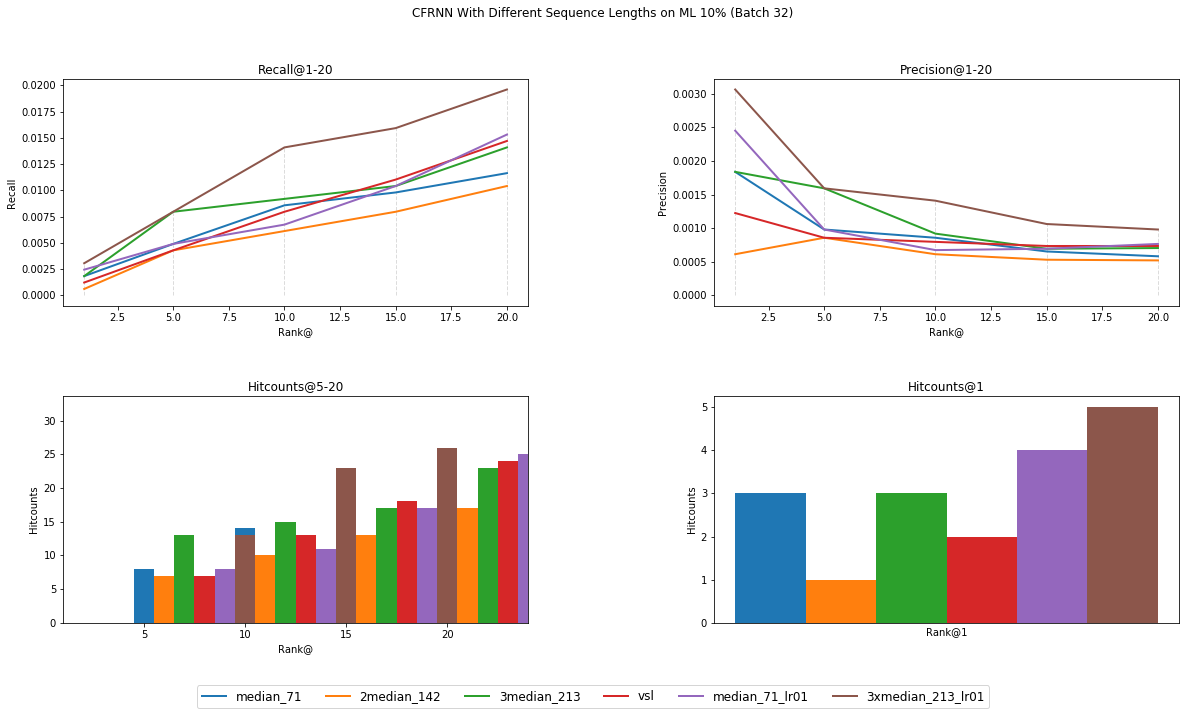

In [31]:
data_path = 'data/ML/'
file_name = 'ML_01_users'
res_path = path + 'results/CFRNN/Results_23_04/'
df = pd.read_pickle(path + data_path + file_name)
legend_names = ['median_71', '2median_142', '3median_213', 'vsl', 'median_71_lr01', '3xmedian_213_lr01']
store_path = ''
title = 'CFRNN With Different Sequence Lengths on ML 10% (Batch 32)'
# print_stats(df)
# /Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/Results/CFRNN/Results_23_04

# cfrnn_vsl_val = pd.read_pickle(res_path + 'metrics_val_CFRNN_vsl_' + file_name)
# cfrnn_71_val = pd.read_pickle(res_path + 'metrics_val_CFRNN_fixed_71_' + file_name)
cfrnn_vsl_test = pd.read_pickle(res_path + 'metrics_test_CFRNN_vsl_' + file_name)
cfrnn_71_test = pd.read_pickle(res_path + 'metrics_test_CFRNN_fixed_71_' + file_name)
cfrnn_142_test = pd.read_pickle(res_path + 'metrics_test_CFRNN_fixed_142_' + file_name)
cfrnn_213_test = pd.read_pickle(res_path + 'metrics_test_CFRNN_fixed_213_' + file_name)
cfrnn_213_test_lr01 = pd.read_pickle(res_path + 'metrics_test_CFRNN_fixed_213_' + file_name + '_lr0.1')
cfrnn_71_test_lr01 = pd.read_pickle(res_path + 'metrics_test_CFRNN_fixed_71_' + file_name + '_lr0.1')


# all_metrics = [cfrnn_71_val, cfrnn_71_test, cfrnn_vsl_val, cfrnn_vsl_test]
all_metrics = [cfrnn_71_test, cfrnn_142_test, cfrnn_213_test, cfrnn_vsl_test, cfrnn_213_test_lr01, cfrnn_71_test_lr01]

show_results(all_metrics, file_name, title, legend_names, size=(20,10), path=store_path)

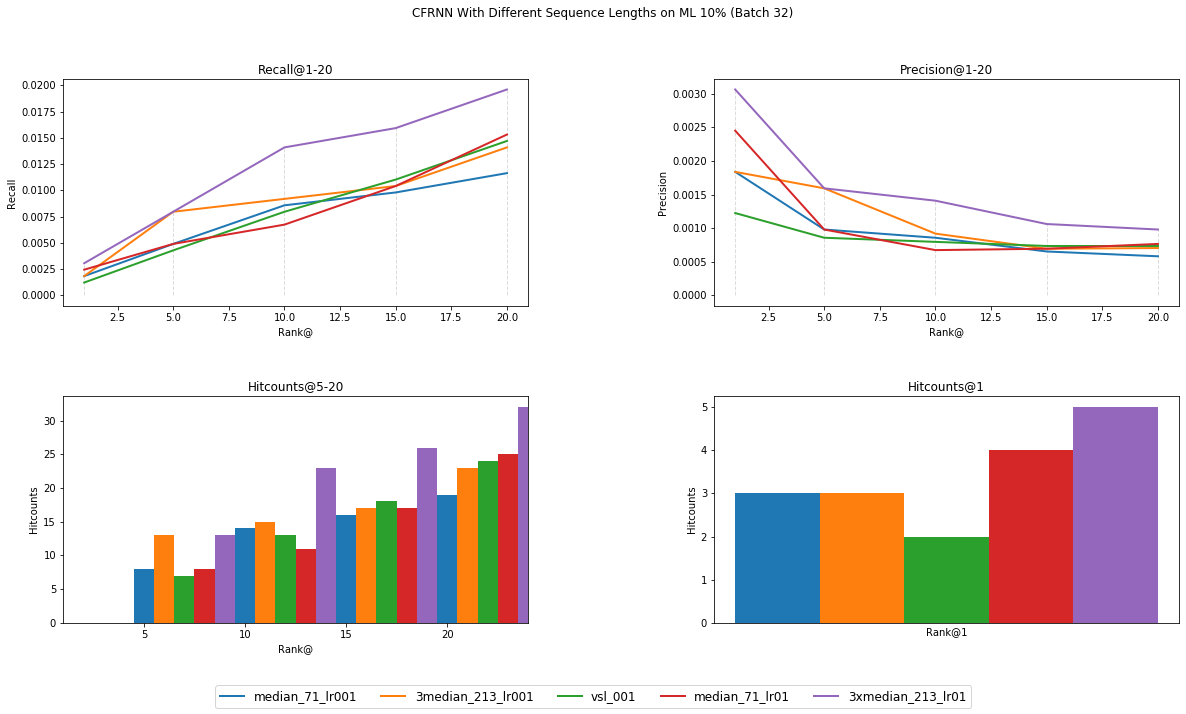

In [30]:
data_path = 'data/ML/'
file_name = 'ML_01_users'
res_path = path + 'results/CFRNN/Results_23_04/'
df = pd.read_pickle(path + data_path + file_name)
legend_names = ['median_71_lr001', '3median_213_lr001', 'vsl_001', 'median_71_lr01', '3xmedian_213_lr01']
store_path = ''
title = 'CFRNN With Different Sequence Lengths on ML 10% (Batch 32)'
# print_stats(df)
# /Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/Results/CFRNN/Results_23_04

# cfrnn_vsl_val = pd.read_pickle(res_path + 'metrics_val_CFRNN_vsl_' + file_name)
# cfrnn_71_val = pd.read_pickle(res_path + 'metrics_val_CFRNN_fixed_71_' + file_name)
cfrnn_vsl_test = pd.read_pickle(res_path + 'metrics_test_CFRNN_vsl_' + file_name)
cfrnn_71_test = pd.read_pickle(res_path + 'metrics_test_CFRNN_fixed_71_' + file_name)
# cfrnn_142_test = pd.read_pickle(res_path + 'metrics_test_CFRNN_fixed_142_' + file_name)
cfrnn_213_test = pd.read_pickle(res_path + 'metrics_test_CFRNN_fixed_213_' + file_name)
cfrnn_213_test_lr01 = pd.read_pickle(res_path + 'metrics_test_CFRNN_fixed_213_' + file_name + '_lr0.1')
cfrnn_71_test_lr01 = pd.read_pickle(res_path + 'metrics_test_CFRNN_fixed_71_' + file_name + '_lr0.1')


# all_metrics = [cfrnn_71_val, cfrnn_71_test, cfrnn_vsl_val, cfrnn_vsl_test]
all_metrics = [cfrnn_71_test, cfrnn_213_test, cfrnn_vsl_test, cfrnn_213_test_lr01, cfrnn_71_test_lr01]

show_results(all_metrics, file_name, title, legend_names, size=(20,10), path=store_path)

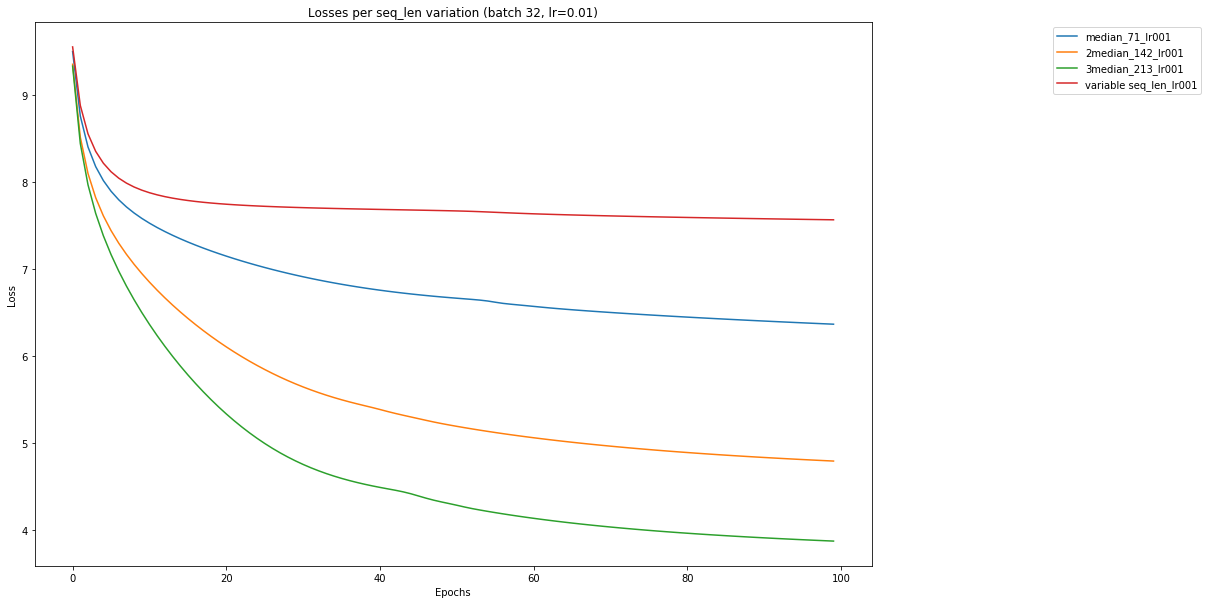

In [20]:
file_names = ['his_fixed_71_01_ml_users_200_epochs', 
              'his_fixed_142_01_ml_users_200_epochs', 
              'his_fixed_213_01_ml_users_200_epochs', 
              'his_vsl_01_ml_users_200_epochs']
legend_names = ['median_71_lr001', '2median_142_lr001', '3median_213_lr001', 'variable seq_len_lr001']

for file_name in file_names:
    plt.plot(pd.read_pickle(res_path + file_name))
plt.legend(legend_names, bbox_to_anchor=(1.40, 1))
plt.title('Losses per seq_len variation (batch 32, lr=0.01)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

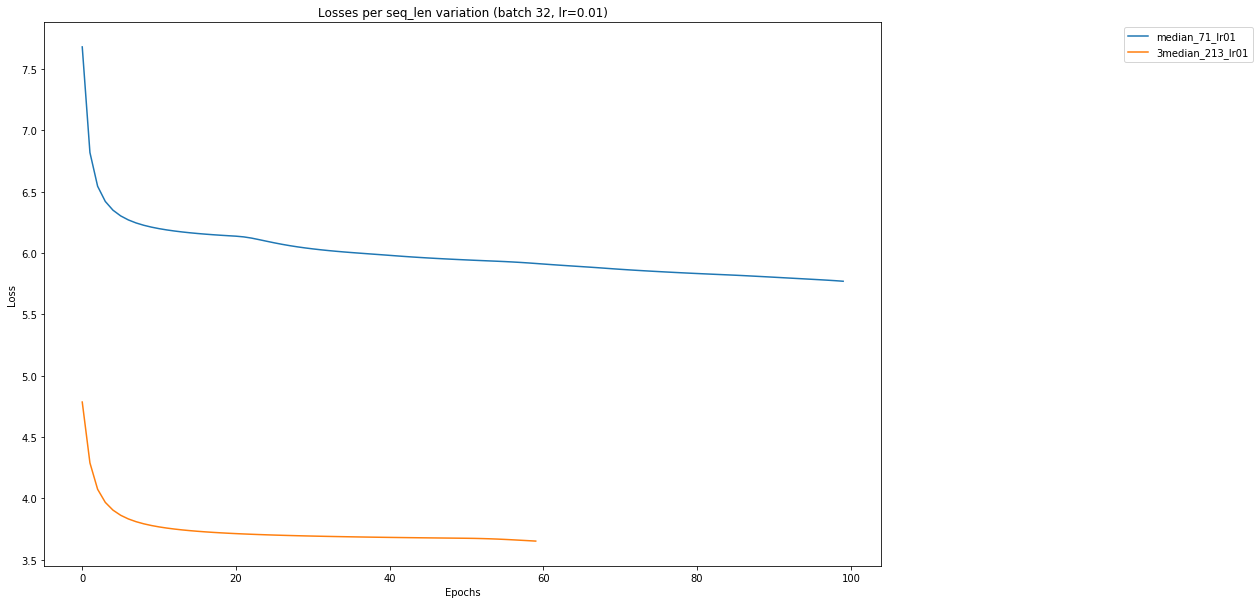

In [21]:
file_names = ['his_fixed_71_01_ml_users_100_epochs_lr0.1', 
#               'his_fixed_142_01_ml_users_100_epochs', 
              'his_fixed_213_01_ml_users_100_epochs_lr0.1']
#               'his_vsl_01_ml_users_100_epochs']
legend_names = ['median_71_lr01', '3median_213_lr01']

for file_name in file_names:
    plt.plot(pd.read_pickle(res_path + file_name))
plt.legend(legend_names, bbox_to_anchor=(1.45, 1))
plt.title('Losses per seq_len variation (batch 32, lr=0.01)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Grid Search Plots

In [13]:
n_iterations = [40]
regs = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 1.5]
nolfs = [20]
alphas = [0.08]
sample_percs = [0.1]
ext = 'ML'

for n_iters in n_iterations:
    for reg in regs:
        for nolf in nolfs:
            for alpha in alphas:
                for sample_perc in sample_percs:
                    # Result name
                    final_name = ext + '_' + str(n_iters) + '_' + str(nolf) + '_' + str(reg) + '_' + str(sample_perc)
                    metric = pd.read_pickle(path + 'Results/BPR/Grid_Search/regularisation/metrics_' + final_name)
                    final_name = ext + '_' + str(n_iters) + '_' + str(nolf) + '_' + str(reg) + '_' + str(alpha) + '_' + str(sample_perc)
                    metric.to_pickle(path + 'Results/BPR/Grid_Search/regularisation/metrics_' + final_name)
                    
                    

In [51]:
def plot_grid_search(n_iterations, regs, nolfs, alphas, sample_percs, ext, param, metric='recall'):
    all_metrics = dict()
    for n_iters in n_iterations:
        for reg in regs:
            for nolf in nolfs:
                for alpha in alphas:
                    for sample_perc in sample_percs:
                        # Result name
                        final_name = ext + '_' + str(n_iters) + '_' + str(nolf) + '_' + str(reg) + '_' + str(alpha) + '_' + str(sample_perc)

                        # Read
                        if param == 'regularisation':
                            value = reg
                            values = regs
                        elif param == 'learning_rate':
                            value = alpha
                            values = alphas
                        
                        all_metrics[value] = pd.read_pickle(path + 'Results/BPR/Grid_Search/' + param + '/metrics_' + final_name)

    import matplotlib.colors as c
    diff_colors = list(c.BASE_COLORS.keys())
    for value, col in zip(values, diff_colors):
        plt.plot(all_metrics[value]['rank_at'], all_metrics[value][metric], c=col)

    plt.title(param)
    plt.xlabel('Rank At')
    plt.ylabel(metric)
    plt.legend(values, bbox_to_anchor=(1.05, 1))
    plt.show()

## Amazon

### Regularisation

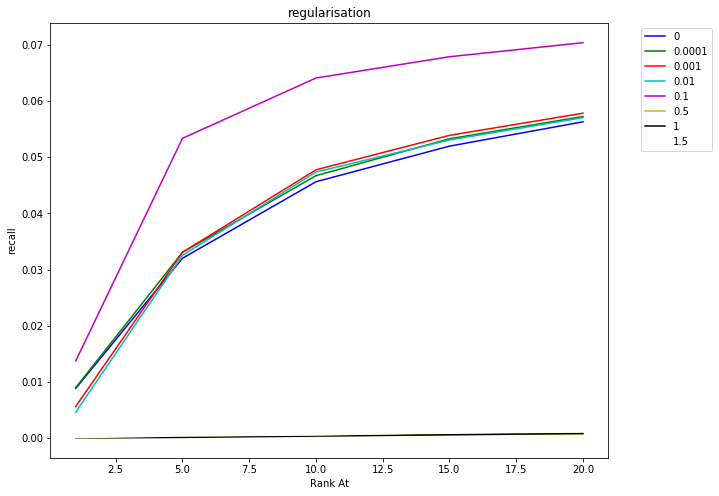

In [52]:
import matplotlib
matplotlib.rc('figure', figsize=(10,8))
file_name = 'Amazon_01_users'
file_path = path + 'Data/Amazon/'
ext = 'Am'
param = 'regularisation'

n_iterations = [40]
regs = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 1.5]
nolfs = [20]
alphas = [0.1]
sample_percs = [0.4]

plot_grid_search(n_iterations, regs, nolfs, alphas, sample_percs, ext, param,'recall')

### Learning Rate

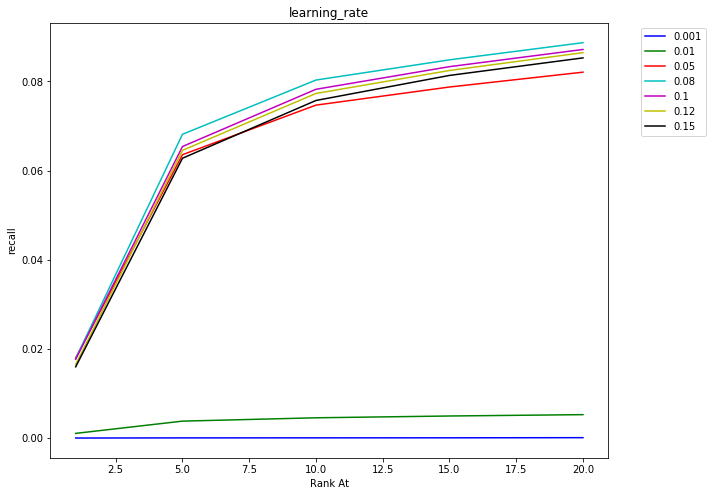

In [53]:
import matplotlib
matplotlib.rc('figure', figsize=(10,8))
file_name = 'Amazon_01_users'
file_path = path + 'Data/Amazon/'
ext = 'Am'
param = 'learning_rate'

n_iterations = [40]
regs = [0.1]
nolfs = [20]
alphas = [0.001, 0.01, 0.05, 0.08, 0.1, 0.12, 0.15]
sample_percs = [0.4]

plot_grid_search(n_iterations, regs, nolfs, alphas, sample_percs, ext, param,'recall')

## MovieLens

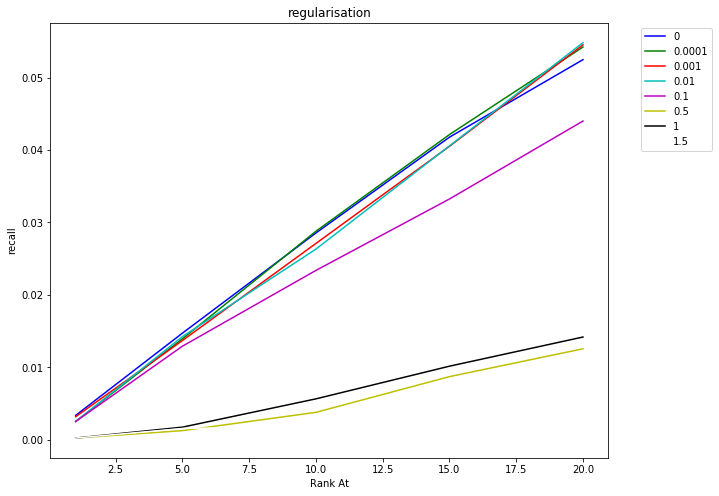

In [54]:
file_name = 'ML_01_users'
file_path = path + 'Data/ML/'
ext = 'ML'
param = 'regularisation'

n_iterations = [40]
regs = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 1.5]
nolfs = [20]
alphas = [0.08]
sample_percs = [0.1]

plot_grid_search(n_iterations, regs, nolfs, alphas, sample_percs, ext, param,'recall')

# Full data stats

In [1]:
path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'

In [147]:
df_amazon = pd.read_pickle(path + '/Data/Amazon/Amazon_full')

In [148]:
df_ml = pd.read_pickle(path + '/Data/ML/ML_full')

In [152]:
print_stats(df_amazon)

rows  10592657 
#ratings/user 8.73 
#ratings/item 28.22 
average rating 4.28 
#users  1213729 
#items  375397 
sparse  0.99998


In [153]:
print_stats(df_ml)

rows  25000095 
#ratings/user 153.81 
#ratings/item 423.39 
average rating 3.53 
#users  162541 
#items  59047 
sparse  0.9974


# CFRNN am Grid Search

In [7]:
res = pd.read_pickle(path + '/results/CFRNN/all_models_am')

In [8]:
res

,model_id,train_time,epochs,BATCH_SIZE,learning_rate,delta,max_seq_len,embedding_dim,rnn_units,val_perc,test_perc,n_items_val,n_items_test,pad_value,shift_targets_by,loss,recall,val_loss,val_recall,test_recall
0,0_am,18013.840090,200,16,0.1,0.2,18,100,20,0.1,0.1,0,1,135784,1,"[2.554909733422284, 2.533241045152025, 2.46037...","[2.9381583e-06, 0.00013195378, 0.0002920571, 0...","[4.938571519190722, 4.908481937823909, 4.74607...","[7.3646435e-05, 0.00019554954, 0.00045513033, ...",0.006154
1,1_am,13535.720657,160,16,0.3,0.2,18,100,20,0.1,0.1,0,1,135784,1,"[2.492791804774054, 2.2577781175157705, 2.2073...","[0.000210802, 0.0020089652, 0.005307905, 0.009...","[4.710240729964606, 4.646537842136799, 4.62718...","[0.0008115798, 0.0032872779, 0.007526714, 0.01...",0.006154
2,5_am,20846.932909,200,32,0.1,0.2,30,100,50,0.1,0.1,0,1,135784,1,"[1.8265074285967597, 1.820659847388714, 1.8136...","[0.0, 0.0, 5.561642e-05, 0.00017923162, 0.0003...","[3.542339720726013, 3.5360026788711547, 3.5261...","[0.0, 0.0, 0.00011016104, 0.00022123894, 0.000...",0.003077
3,6_am,22982.548593,200,32,0.3,0.2,30,100,50,0.1,0.1,0,1,135784,1,"[1.8206264367831753, 1.7478289891933572, 1.602...","[1.6873295e-05, 0.0003124849, 0.0017495692, 0....","[3.5291484594345093, 3.3599658823013305, 3.323...","[9.494675e-05, 0.00086618867, 0.0027825893, 0....",0.005538
4,7_am,28558.309178,200,16,0.1,0.6,18,100,20,0.1,0.1,0,1,135784,1,"[0.48747242005367586, 0.4793317374576048, 0.46...","[0.0, 5.3082982e-05, 0.00014864586, 0.00021017...","[3.3119295375181896, 3.302900663696893, 3.2845...","[0.0, 0.00010310501, 0.00016938652, 0.00022666...",0.006154
5,8_am,30543.622423,161,16,0.3,0.6,18,100,20,0.1,0.1,0,1,135784,1,"[0.47687314659026747, 0.3434375589208797, 0.27...","[7.4939e-05, 0.00035860614, 0.0007600899, 0.00...","[3.27543308239172, 3.2868811257995003, 3.33043...","[0.0001913656, 0.00055657554, 0.0010071265, 0....",0.009231
6,9_am,28914.833008,172,16,0.1,0.6,30,100,20,0.1,0.1,0,1,135784,1,"[0.36525425487863167, 0.36047429656105234, 0.3...","[0.0, 1.0721208e-05, 0.000107472086, 0.0001692...","[2.378137436243567, 2.3730297124031745, 2.3672...","[0.0, 8.837572e-05, 0.00016628666, 0.000169386...",0.003077
7,10_am,32447.180922,172,16,0.3,0.6,30,100,20,0.1,0.1,0,1,135784,1,"[0.35959263617549037, 0.2782717178589458, 0.20...","[5.1701416e-05, 0.00027426844, 0.0005778312, 0...","[2.360568891657461, 2.3202049153866153, 2.3722...","[0.00016938652, 0.000488495, 0.00066382345, 0....",0.006154
8,2_am,37728.076944,200,32,0.1,0.6,18,100,20,0.1,0.1,0,1,135784,1,"[0.48949657668694485, 0.48542612732337614, 0.4...","[0.0, 0.0, 1.3075499e-05, 9.339205e-05, 0.0001...","[3.317415142059326, 3.3130080938339233, 3.3085...","[0.0, 0.0, 8.7734064e-05, 0.00010310488, 0.000...",0.006154
9,3_am,36173.264363,200,32,0.3,0.6,18,100,20,0.1,0.1,0,1,135784,1,"[0.4853863109251842, 0.46703839228658256, 0.37...","[5.960496e-06, 0.00014358677, 0.00027341425, 0...","[3.3082576990127563, 3.272194962501526, 3.2140...","[8.837564e-05, 0.00020663152, 0.00039936486, 0...",0.012308


In [37]:
res.iloc[5]['val_recall']

[0.0001913656,
 0.00055657554,
 0.0010071265,
 0.0011707979,
 0.001433019,
 0.0018216192,
 0.0022003504,
 0.0026241888,
 0.0028627336,
 0.002974679,
 0.0030141838,
 0.003029896,
 0.0031457553,
 0.003332919,
 0.0035886688,
 0.0038619812,
 0.0042301654,
 0.0047074943,
 0.0051239473,
 0.005608476,
 0.0060835294,
 0.00662319,
 0.007142458,
 0.0075648176,
 0.008016025,
 0.008342559,
 0.008671053,
 0.008889514,
 0.009079834,
 0.009236331,
 0.009379348,
 0.009474179,
 0.009540961,
 0.009580105,
 0.009635609,
 0.0096665565,
 0.009683935,
 0.0097178165,
 0.009749058,
 0.009806487,
 0.009805591,
 0.009843849,
 0.009846367,
 0.009880295,
 0.009908328,
 0.009973116,
 0.010002262,
 0.0100340145,
 0.0100795245,
 0.010116993,
 0.010161384,
 0.010221738,
 0.010291894,
 0.010356539,
 0.010419672,
 0.010514036,
 0.0106185675,
 0.010750726,
 0.010884576,
 0.011049638,
 0.011184949,
 0.011296464,
 0.011443186,
 0.0115539115,
 0.01171226,
 0.011925201,
 0.012070979,
 0.012242068,
 0.012369134,
 0.01252427,

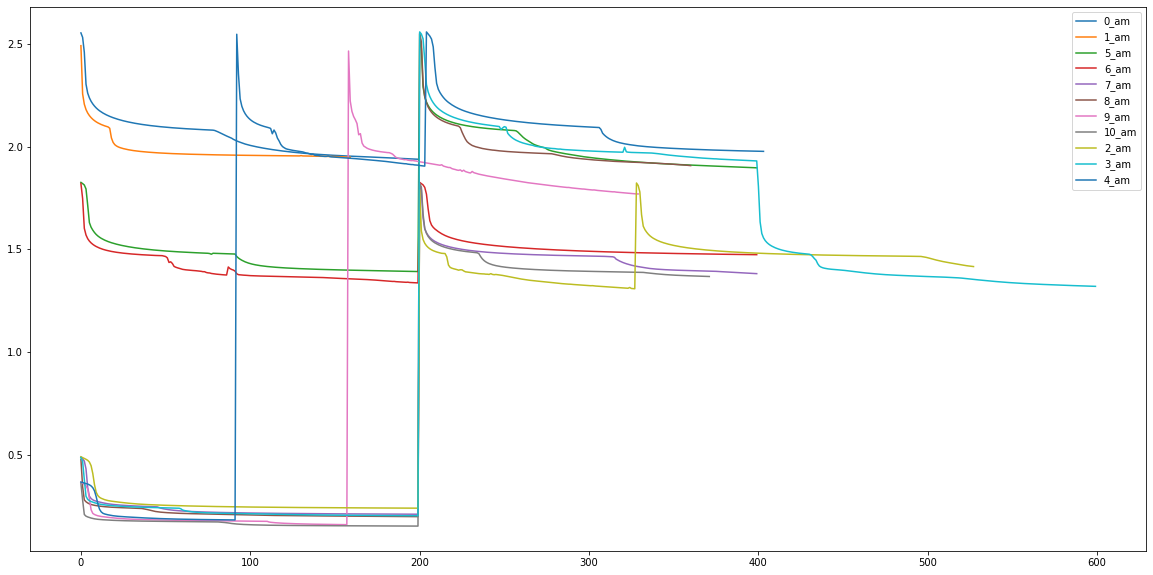

In [65]:
fig = plt.figure(figsize=(20,10))
for val_recall, epochs in zip(res['loss'], res['epochs']):
    plt.plot(range(len(val_recall)), val_recall)
plt.legend(res['model_id'])
plt.show()

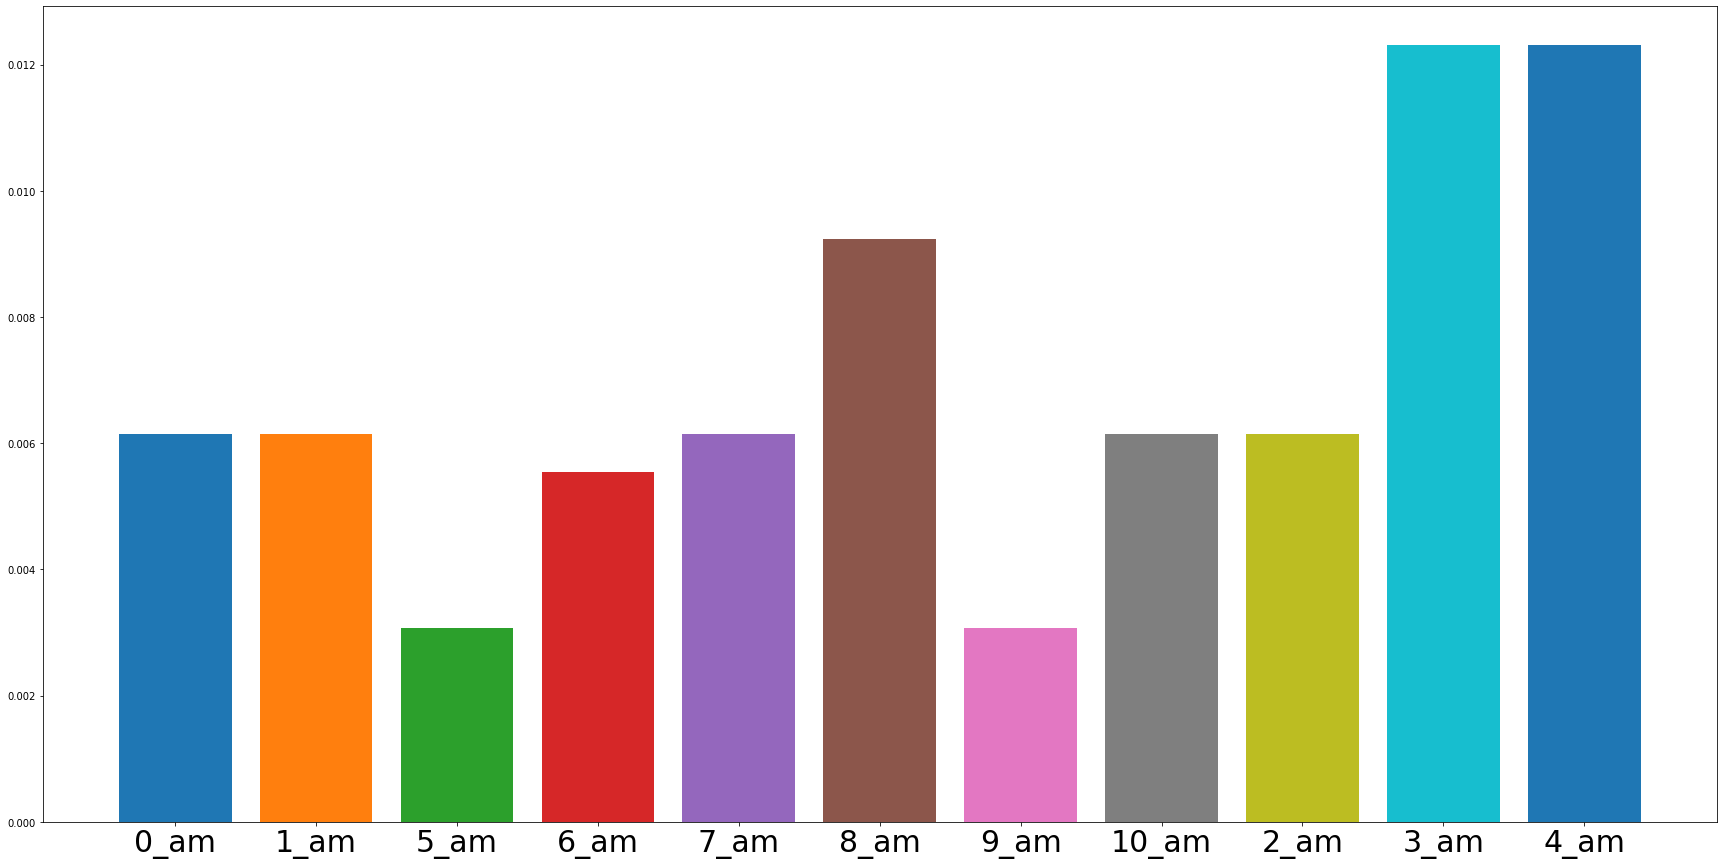

In [64]:
fig = plt.figure(figsize=(30,15))
ticks = []
labels = []
for i, row in res.iterrows():
    plt.bar(i, row[-1])
    labels.append(row[0])
    ticks.append(i)
plt.xticks(ticks, labels, fontsize=30)
plt.show()